In [1]:
!pip install ugtm
!pip install ucimlrepo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 12.6 MB/s eta 0:00:00
  Created wheel for ugtm: filename=ugtm-2.1.0.post2-py3-none-any.whl size=39461 sha256=04f331214f53e92ae418e6cea9ae44ac90d41a9f2da4eddf28d27607a1db897b
  Stored in directory: /root/.cache/pip/wheels/02/8c/1a/888cbb5d049abd27bf5f4b0d37715f6c48d494409e6a32088e
Successfully built ugtm


In [2]:
import itertools
import warnings
import wandb
import time
import math
import os
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.utils._param_validation import StrOptions
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, validate_data
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, PolynomialFeatures, LabelEncoder, Normalizer
from sklearn.linear_model import LinearRegression, Ridge, RidgeClassifier, Lasso, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import euclidean_distances, make_scorer, precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef, accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin, OneToOneFeatureMixin, _fit_context
from sklearn.svm import LinearSVC, LinearSVR, SVR, SVC
from ugtm import eGTC
from ucimlrepo import fetch_ucirepo

from google.colab import drive
from typing import Optional

In [3]:
def warn(*args, **kwargs):
    pass

warnings.warn = warn
drive.mount('/content/drive', force_remount=True)

%matplotlib inline

Mounted at /content/drive


# Helper functions

In [9]:
class DoubleNormalizer(OneToOneFeatureMixin, TransformerMixin, BaseEstimator):
     _parameter_constraints: dict = {
        "norm": [StrOptions({"l1", "l2", "max"})],
        "copy": ["boolean"],
     }

     def __init__(self, norm="l2", *, copy=True):
        self.norm = norm
        self.copy = copy

     def fit(self, X, y=None):
        return self

     def transform(self, X, copy=None):
        X = validate_data(
            self, X, accept_sparse="csr", force_writeable=True, copy=copy, reset=False
        )
        return double_l2_norm(X)

In [10]:
def double_l2_norm(X):
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    normed_X = X / norms
    normed_X = np.nan_to_num(normed_X, nan=0)

    assert normed_X.shape == X.shape
    #assert np.allclose(np.sum(normed_X ** 2, axis=1), np.ones(X.shape[0])) == True

    normed_X = np.hstack((normed_X, norms))

    new_norms = np.linalg.norm(normed_X, axis=1, keepdims=True)
    normed_2_X = normed_X / new_norms
    normed_2_X = np.nan_to_num(normed_2_X, nan=0)

    assert normed_X.shape[1] == X.shape[1] + 1
    #assert np.allclose(np.sum(normed_2_X ** 2, axis=1), np.ones(X.shape[0])) == True

    return normed_2_X

In [11]:
def l2_norm(X):
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    normed_X = X / norms
    normed_X = np.nan_to_num(normed_X, nan=0)

    assert normed_X.shape == X.shape
    #assert np.allclose(np.sum(normed_X ** 2, axis=1), np.ones(X.shape[0])) == True

    return normed_X

In [12]:
def run_model(data, scoring_config, estimator_, args):
        X, y = data
        pipeline_params, model_params = args

        model = estimator_(**model_params)

        pipeline = Pipeline(list(pipeline_params.values()))
        pipeline.steps.append(('model', model))

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scoring = {key: value['scorer'] for key, value in scoring_config.items()}
        scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, return_train_score=True)

        metrics, formatted_metrics = {}, {}
        for metric_name, scorer in scoring.items():
            train_metric_name, test_metric_name = 'train_' + metric_name, 'test_' + metric_name

            train_scores = scores[train_metric_name]
            test_scores = scores[test_metric_name]

            mean_train_scores, std_train_scores = np.round(np.mean(train_scores), 3), np.round(np.std(train_scores), 3)
            mean_test_scores, std_test_scores = np.round(np.mean(test_scores), 3), np.round(np.std(test_scores), 3)

            if scoring_config[metric_name]['convert_to_%']:
                mean_train_scores, std_train_scores = np.round(mean_train_scores * 100, 1), np.round(std_train_scores * 100, 1)
                mean_test_scores, std_test_scores = np.round(mean_test_scores * 100, 1), np.round(std_test_scores * 100, 1)

            metrics[train_metric_name + '_mean'], metrics[train_metric_name + '_std'] = mean_train_scores, std_train_scores
            metrics[test_metric_name + '_mean'], metrics[test_metric_name + '_std'] = mean_test_scores, std_test_scores

            formatted_metrics[train_metric_name] = f'{mean_train_scores} ± {std_train_scores}'
            formatted_metrics[test_metric_name] = f'{mean_test_scores} ± {std_test_scores}'

        return formatted_metrics, metrics


def run_experiments(scoring_config, estimator, data, data_prep_config={}, model_config={}, project_name=None, print_info=False):
    def get_name(obj):
        return obj.__name__ if hasattr(obj, '__name__') else obj

    formatted_results, results = [], []
    experiment_id = 1

    if project_name is not None:
        api = wandb.Api()
        runs = api.runs(f"diploma_work/{project_name}")
        try:
            for run in runs:
                run.delete()
        except ValueError:
            pass

    param_names = list(model_config.keys())
    param_values = [model_config[param] for param in param_names]

    data_prep_step_names = list(data_prep_config.keys())
    data_prep_step_values = [data_prep_config[data_prep_step_name] for data_prep_step_name in data_prep_step_names]

    for param_combination in itertools.product(*param_values):
        param_dict = dict(zip(param_names, param_combination))
        for prep_step_combination in itertools.product(*data_prep_step_values):
            pipeline_dict = dict(zip(data_prep_step_names, prep_step_combination))
            if print_info:
                print('---------------------------')
                print(f'EXPERIMENT #{experiment_id}')
                print()

                for param in param_dict.keys():
                    print(f'{param}: {get_name(param)}')

                for step in pipeline_dict.keys():
                    print(f'{step}: {get_name(step)}')

                print('---------------------------\n\n')
                print()

            if project_name is not None:
                # wandb_config = {'data_type': data_type,
                #                 'row_scaler': row_scaler.__name__ if row_scaler is not None else 'None',
                #                 'column_scaler': column_scaler.__name__,
                #                 'y_calc_method': y_calc_method,
                #                 'model_baseline': estimator}

                #with wandb.init(config=wandb_config, name=f'Ex. {ex_id}', project=project):
                #wandb.log(metrics)
                pass

            formatted_metrics, metrics = run_model(data, scoring_config, estimator, [pipeline_dict, param_dict])
            formatted_metrics['experiment_id'], metrics['experiment_id'] = experiment_id, experiment_id

            for param, value in param_dict.items():
                val_name = get_name(value)
                val_name = naming_map[val_name] if val_name in naming_map.keys() else val_name
                formatted_metrics[param], metrics[param] = val_name, val_name

            for param, value in pipeline_dict.items():
                val_name = value[0]
                formatted_metrics[param], metrics[param] = val_name, val_name

            estimator_name = get_name(estimator)
            formatted_metrics['model'] = naming_map[estimator_name] if estimator_name in naming_map.keys() else estimator_name
            metrics['model'] = naming_map[estimator_name] if estimator_name in naming_map.keys() else estimator_name

            results.append(metrics)
            formatted_results.append(formatted_metrics)
            experiment_id += 1

    return pd.DataFrame(formatted_results), pd.DataFrame(results)

In [17]:
def plot_first_vs_baseline(best_results: pd.Series, baseline_best_results: pd.Series):
    best_value = best_results.iloc[0]
    best_label = 'Розроблений метод'

    x = np.arange(len(baseline_best_results))
    width = 0.35

    fig, ax = plt.subplots()

    ax.bar(x, baseline_best_results.values, width, label='Існуючі ансамблі')

    ax.axhline(best_value, color='red', linestyle='--', label=best_label)

    ax.set_ylabel('Середнє значення тестової F1-Міри')
    ax.set_title(f'Порівняння розробленого методу і існуючих ансамблей')
    ax.set_xticks(x)
    ax.set_ylim(0, 100)
    ax.set_xticklabels(baseline_best_results.index, rotation=45, ha='right')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.grid(axis='y')

    plt.tight_layout()
    plt.show()

In [18]:
def run_dataset(
    X,
    y,
    proposed_method,
    baseline_methods,
    scoring_config,
    proposed_method_config=None,
    baseline_methods_configs=None,
    target_metric='test_f1_score',
    print_info=False,
    plot_func=None,
):
    def default_plot(best_results: pd.Series, baseline_best_results: pd.Series):
        best_mapped = best_results.rename(lambda x: naming_map.get(x, x))
        baseline_mapped = baseline_best_results.rename(lambda x: naming_map.get(x, x))

        all_models = best_mapped.index.union(baseline_mapped.index)
        best_aligned = best_mapped.reindex(all_models)
        baseline_aligned = baseline_mapped.reindex(all_models)

        x = np.arange(len(all_models))
        width = 0.35

        fig, ax = plt.subplots()
        ax.bar(x - width/2, baseline_aligned.values, width, label='Існуючі лінійні методи')
        ax.bar(x + width/2, best_aligned.values, width, label='Розроблений метод')

        ax.set_ylabel('Середнє значення тестової F1-Міри')
        ax.set_title('Порівняння розробленого методу і існуючих лінійних методів')
        ax.set_xticks(x)
        ax.set_ylim(0, 100)
        ax.set_xticklabels(all_models, rotation=45, ha='right')
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
        ax.grid(axis='y')

        plt.tight_layout()
        plt.show()

    if baseline_methods_configs is None:
        baseline_methods_configs = [{}] * len(baseline_methods)

    if proposed_method_config is None:
        proposed_method_config = {}

    metrics_formatted, metrics = run_experiments(
        scoring, Ensemble, (X, y),
        model_config=proposed_method_config,
        print_info=print_info
    )

    print('ALL EXPERIMENTS')
    display(metrics_formatted)
    best_results = metrics.groupby('estimator')[target_metric + '_mean'].max()

    #assert best_results.size == len(baseline_methods)

    base_line_formatted_metrics, base_line_metrics = pd.DataFrame(), pd.DataFrame()
    for baseline_model, baseline_config in zip(baseline_methods, baseline_methods_configs):
        base_line_formatted_metric, base_line_metric = run_experiments(
            scoring, baseline_model, (X, y),
            pipeline_regression_config, baseline_config,
            print_info=print_info
        )
        base_line_formatted_metrics = pd.concat([base_line_formatted_metrics, base_line_formatted_metric])
        base_line_metrics = pd.concat([base_line_metrics, base_line_metric])

    print('BASELINE EXPERIMENTS')
    display(base_line_formatted_metrics)

    baseline_best_results = base_line_metrics.groupby('model')[target_metric + '_mean'].max()

    #assert baseline_best_results.size == best_results.size

    print('BEST RESULTS')
    display(best_results)

    print('BASELINE BEST RESULTS')
    display(baseline_best_results)

    if plot_func is None:
        plot_func = default_plot

    plot_func(best_results, baseline_best_results)

# Proposed method

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef, accuracy_score

class Ensemble(BaseEstimator, ClassifierMixin):

    def __init__(self, estimator, column_scaler, row_scaler, y_calc_method='norm'):
        self.estimator = estimator
        self.row_scaler = row_scaler
        self.column_scaler = column_scaler

        self.estimator_instances = {}
        self.column_scaler_instances = {}
        self.y_stats = {}

        self.y_calc_method = y_calc_method

    def fit(self, X, y):
        assert X.shape[0] == y.shape[0]
        # scaler = self.column_scaler()
        # X = scaler.fit_transform(X)
        #X_subsets = self.split_X_by_labels(X, y)
        idx = 0

        #for label in X_subsets.keys():)
        for label in np.unique(y):

            column_scaler_instance = self.column_scaler()
            # if self.estimator == LinearRegression or self.estimator == Ridge or self.estimator == Lasso:
            #     weak_estimator = self.estimator()
            # else:
            weak_estimator = self.estimator()

            #X_ = X_subsets[label]
            X_normed = column_scaler_instance.fit_transform(X)

            if self.row_scaler is not None:
                X_normed = self.row_scaler(X_normed)

            y_ = (y == label).astype(float) #np.ones(X_.shape[0])

            weak_estimator.fit(X_normed, y_)
            self.estimator_instances[label] = weak_estimator
            self.column_scaler_instances[label] = column_scaler_instance

            preds = weak_estimator.predict(X_normed)
            self.y_stats[label] = (preds.min(), preds.max())
            idx += 1

        return self

    def predict(self, X_):
        all_preds = []
        for label, estimator in self.estimator_instances.items():
            X = X_.copy()
            X = self.column_scaler_instances[label].transform(X)
            if self.row_scaler is not None:
                X = self.row_scaler(X)
            preds = estimator.predict(X)

            if self.y_calc_method == 'diff':
                preds = self.calculate_as_diff(preds, self.y_stats[label][0])
            elif self.y_calc_method == 'norm':
                preds = self.calculate_as_norm(preds, self.y_stats[label][0], self.y_stats[label][1])

            all_preds.append(np.expand_dims(preds, axis=1))

        all_preds = np.concatenate(all_preds, axis=1)
        y_preds = np.argmax(all_preds, axis=1)

        return y_preds

    def calculate_as_diff(self, preds, y_min, eps=2e-9):
        return preds - y_min + eps

    def calculate_as_norm(self, preds, y_min, y_max, eps=2e-9):
        return (preds - y_min) / ((y_max - y_min) + eps)

    def split_X_by_labels(self, X, y):
        X_subsets = {}

        for label in y.unique():
            X_subsets[label] = X[y == label]

        return X_subsets

# Config



In [16]:
scoring = { 'accuracy': {'scorer': make_scorer(accuracy_score), 'convert_to_%': True},
            'precision': {'scorer': make_scorer(precision_score, average='macro'), 'convert_to_%': True},
            'recall': {'scorer': make_scorer(recall_score, average='macro'), 'convert_to_%': True},
            'f1_score': {'scorer': make_scorer(f1_score, average='macro'), 'convert_to_%': True},
            'matthews_corrcoef': {'scorer': make_scorer(matthews_corrcoef), 'convert_to_%': False},
            'cohen_kappa': {'scorer': make_scorer(cohen_kappa_score), 'convert_to_%': False}}

config = {'estimator': [GTM, Ridge, LinearSVR],
          'row_scaler': [None, l2_norm, double_l2_norm],
          'column_scaler': [MaxAbsScaler],
          'y_calc_method': ['norm', 'diff', 'none']
          }

pipeline_regression_config = {'column norm': [('max abs column norm', MaxAbsScaler())],
                              'row norm': [('No Row Norm', 'passthrough'), ('Row Normalizer', Normalizer()), ('Double Row Normalizer', DoubleNormalizer())]}

naming_map = {
    'RandomForestRegressor': 'RF',
    'RandomForestClassifier': 'RF',
    'GTM': 'GTM',
    'eGTC': 'GTM',
    'GTMClassifier': 'GTM',
    'Ridge': 'Ridge',
    'RidgeClassifier': 'Ridge',
    'SVR': 'SVM',
    'SVC': 'SVM',
    'LinearSVR': 'SVM',
    'LinearSVC': 'SVM',
    'AdaBoostClassifier': 'AdaBoost',
    'GradientBoostingClassifier': 'XGBoost'
}

# Stupnytskiy's dataset

In [31]:
X.shape

(72, 56)

In [30]:
train, test = pd.read_csv('/content/drive/MyDrive/Datasets/StupnytskiyTrain.txt', sep=',', header=None), pd.read_csv('/content/drive/MyDrive/Datasets/StupnytskiyTest.txt', sep=',', header=None)
X_train, y_train = train.drop(train.columns[-1], axis=1), train[train.columns[-1]]
X_test, y_test = test.drop(test.columns[-1], axis=1), test[test.columns[-1]]

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

ALL EXPERIMENTS


,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1_score,test_f1_score,train_matthews_corrcoef,test_matthews_corrcoef,train_cohen_kappa,test_cohen_kappa,experiment_id,estimator,row_scaler,column_scaler,y_calc_method,model
0,96.2 ± 3.0,77.6 ± 11.8,96.0 ± 3.0,80.7 ± 11.0,96.6 ± 2.7,79.3 ± 11.1,96.1 ± 3.0,77.4 ± 11.9,0.926 ± 0.056,0.6 ± 0.22,0.923 ± 0.06,0.565 ± 0.23,1,GTM,None,MaxAbsScaler,norm,Ensemble
1,96.2 ± 3.0,77.6 ± 11.8,96.0 ± 3.0,80.7 ± 11.0,96.6 ± 2.7,79.3 ± 11.1,96.1 ± 3.0,77.4 ± 11.9,0.926 ± 0.056,0.6 ± 0.22,0.923 ± 0.06,0.565 ± 0.23,2,GTM,None,MaxAbsScaler,diff,Ensemble
2,97.6 ± 2.6,72.1 ± 5.0,97.6 ± 2.7,74.6 ± 6.8,97.4 ± 2.7,72.1 ± 3.1,97.5 ± 2.7,71.2 ± 4.0,0.95 ± 0.054,0.465 ± 0.089,0.95 ± 0.054,0.438 ± 0.076,3,GTM,None,MaxAbsScaler,none,Ensemble
3,96.2 ± 3.0,77.6 ± 11.8,96.0 ± 3.0,80.7 ± 11.0,96.6 ± 2.7,79.3 ± 11.1,96.1 ± 3.0,77.4 ± 11.9,0.926 ± 0.056,0.6 ± 0.22,0.923 ± 0.06,0.565 ± 0.23,4,GTM,l2_norm,MaxAbsScaler,norm,Ensemble
4,96.2 ± 3.0,77.6 ± 11.8,96.0 ± 3.0,80.7 ± 11.0,96.6 ± 2.7,79.3 ± 11.1,96.1 ± 3.0,77.4 ± 11.9,0.926 ± 0.056,0.6 ± 0.22,0.923 ± 0.06,0.565 ± 0.23,5,GTM,l2_norm,MaxAbsScaler,diff,Ensemble
5,98.3 ± 1.9,72.1 ± 5.0,98.3 ± 1.9,74.6 ± 6.8,98.2 ± 2.1,72.1 ± 3.1,98.2 ± 2.0,71.2 ± 4.0,0.964 ± 0.039,0.465 ± 0.089,0.964 ± 0.04,0.438 ± 0.076,6,GTM,l2_norm,MaxAbsScaler,none,Ensemble
6,95.1 ± 3.0,77.6 ± 11.8,95.0 ± 2.7,80.7 ± 11.0,95.7 ± 2.6,79.3 ± 11.1,95.1 ± 3.0,77.4 ± 11.9,0.907 ± 0.053,0.6 ± 0.22,0.902 ± 0.06,0.565 ± 0.23,7,GTM,double_l2_norm,MaxAbsScaler,norm,Ensemble
7,95.1 ± 3.0,77.6 ± 11.8,95.0 ± 2.7,80.7 ± 11.0,95.7 ± 2.6,79.3 ± 11.1,95.1 ± 3.0,77.4 ± 11.9,0.907 ± 0.053,0.6 ± 0.22,0.902 ± 0.06,0.565 ± 0.23,8,GTM,double_l2_norm,MaxAbsScaler,diff,Ensemble
8,98.3 ± 1.6,70.8 ± 5.4,98.2 ± 1.6,73.0 ± 7.6,98.3 ± 1.6,70.4 ± 3.3,98.2 ± 1.6,69.7 ± 4.3,0.964 ± 0.032,0.432 ± 0.102,0.964 ± 0.032,0.408 ± 0.085,9,GTM,double_l2_norm,MaxAbsScaler,none,Ensemble
9,95.5 ± 2.4,79.1 ± 8.5,95.3 ± 2.5,81.0 ± 8.3,95.9 ± 2.1,80.1 ± 7.1,95.4 ± 2.4,79.0 ± 8.3,0.911 ± 0.046,0.611 ± 0.154,0.908 ± 0.048,0.589 ± 0.158,10,Ridge,None,MaxAbsScaler,norm,Ensemble


BASELINE EXPERIMENTS


,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1_score,test_f1_score,train_matthews_corrcoef,test_matthews_corrcoef,train_cohen_kappa,test_cohen_kappa,experiment_id,column norm,row norm,model
0,97.2 ± 2.6,70.7 ± 5.9,97.1 ± 2.7,72.9 ± 8.0,97.1 ± 2.7,70.4 ± 4.2,97.1 ± 2.7,69.7 ± 4.9,0.943 ± 0.054,0.431 ± 0.114,0.943 ± 0.054,0.407 ± 0.097,1,max abs column norm,No Row Norm,GTM
1,97.9 ± 2.0,72.1 ± 5.0,97.9 ± 2.0,74.6 ± 6.8,97.9 ± 2.2,72.1 ± 3.1,97.8 ± 2.1,71.2 ± 4.0,0.957 ± 0.042,0.465 ± 0.089,0.957 ± 0.042,0.438 ± 0.076,2,max abs column norm,Row Normalizer,GTM
2,98.3 ± 1.6,70.8 ± 5.4,98.2 ± 1.6,73.0 ± 7.6,98.3 ± 1.6,70.4 ± 3.3,98.2 ± 1.6,69.7 ± 4.3,0.964 ± 0.032,0.432 ± 0.102,0.964 ± 0.032,0.408 ± 0.085,3,max abs column norm,Double Row Normalizer,GTM
0,97.6 ± 1.4,79.2 ± 4.0,97.5 ± 1.4,80.9 ± 5.9,97.6 ± 1.5,78.6 ± 5.2,97.5 ± 1.4,78.2 ± 4.4,0.95 ± 0.029,0.592 ± 0.098,0.95 ± 0.029,0.571 ± 0.088,1,max abs column norm,No Row Norm,Ridge
1,85.8 ± 3.0,78.9 ± 15.2,85.3 ± 3.1,79.6 ± 15.6,85.6 ± 3.1,78.5 ± 15.1,85.4 ± 3.0,78.4 ± 15.1,0.71 ± 0.061,0.579 ± 0.305,0.709 ± 0.061,0.57 ± 0.3,2,max abs column norm,Row Normalizer,Ridge
2,58.3 ± 0.4,58.3 ± 1.4,29.2 ± 0.2,29.1 ± 0.7,50.0 ± 0.0,50.0 ± 0.0,36.8 ± 0.1,36.8 ± 0.6,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,3,max abs column norm,Double Row Normalizer,Ridge
0,99.3 ± 0.8,77.8 ± 2.3,99.3 ± 0.9,79.1 ± 4.9,99.3 ± 0.9,76.9 ± 2.9,99.3 ± 0.9,76.8 ± 2.4,0.986 ± 0.017,0.558 ± 0.058,0.986 ± 0.017,0.541 ± 0.049,1,max abs column norm,No Row Norm,SVM
1,88.2 ± 4.0,83.1 ± 10.8,87.8 ± 4.0,83.9 ± 11.2,88.3 ± 4.1,83.1 ± 11.0,88.0 ± 4.1,82.7 ± 10.8,0.761 ± 0.081,0.669 ± 0.218,0.759 ± 0.081,0.657 ± 0.215,2,max abs column norm,Row Normalizer,SVM
2,67.0 ± 3.5,61.1 ± 7.0,79.3 ± 3.6,50.2 ± 26.0,60.7 ± 4.0,53.8 ± 7.9,56.6 ± 6.7,45.1 ± 11.9,0.346 ± 0.081,0.11 ± 0.254,0.238 ± 0.088,0.082 ± 0.175,3,max abs column norm,Double Row Normalizer,SVM


BEST RESULTS


,test_f1_score_mean
estimator,
GTM,77.4
Ridge,84.3
SVM,85.9


BASELINE BEST RESULTS


,test_f1_score_mean
model,
GTM,71.2
Ridge,78.4
SVM,82.7


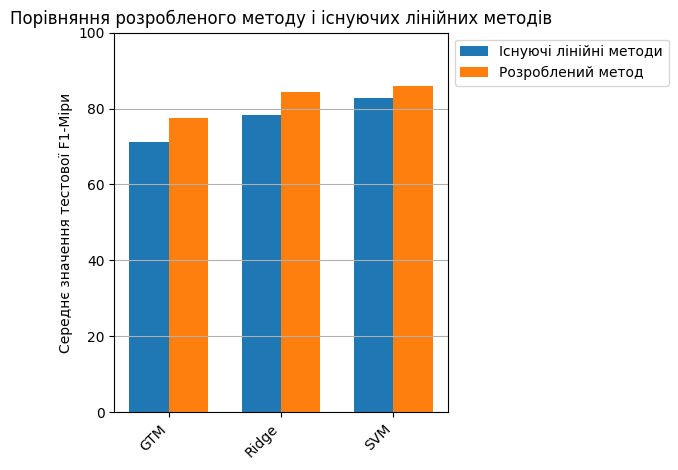

In [20]:
run_dataset(X, y, Ensemble, [GTMClassifier, RidgeClassifier, LinearSVC], scoring, config)

ALL EXPERIMENTS


,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1_score,test_f1_score,train_matthews_corrcoef,test_matthews_corrcoef,train_cohen_kappa,test_cohen_kappa,experiment_id,estimator,row_scaler,column_scaler,y_calc_method,model
0,94.4 ± 2.3,86.0 ± 4.7,94.2 ± 2.2,86.8 ± 4.6,94.9 ± 2.1,87.5 ± 4.9,94.3 ± 2.3,85.9 ± 4.7,0.89 ± 0.043,0.743 ± 0.095,0.887 ± 0.047,0.723 ± 0.093,1,SVM,None,MaxAbsScaler,norm,Ensemble
1,94.4 ± 2.3,86.0 ± 4.7,94.2 ± 2.2,86.8 ± 4.6,94.9 ± 2.1,87.5 ± 4.9,94.3 ± 2.3,85.9 ± 4.7,0.89 ± 0.043,0.743 ± 0.095,0.887 ± 0.047,0.723 ± 0.093,2,SVM,None,MaxAbsScaler,norm,Ensemble


BASELINE EXPERIMENTS


,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1_score,test_f1_score,train_matthews_corrcoef,test_matthews_corrcoef,train_cohen_kappa,test_cohen_kappa,experiment_id,column norm,row norm,model
0,100.0 ± 0.0,81.6 ± 14.9,100.0 ± 0.0,81.6 ± 15.6,100.0 ± 0.0,80.6 ± 16.3,100.0 ± 0.0,80.2 ± 16.4,1.0 ± 0.0,0.621 ± 0.319,1.0 ± 0.0,0.611 ± 0.319,1,max abs column norm,No Row Norm,AdaBoost
1,100.0 ± 0.0,77.6 ± 12.3,100.0 ± 0.0,78.0 ± 12.4,100.0 ± 0.0,76.9 ± 11.5,100.0 ± 0.0,77.0 ± 12.2,1.0 ± 0.0,0.549 ± 0.238,1.0 ± 0.0,0.545 ± 0.238,2,max abs column norm,Row Normalizer,AdaBoost
2,100.0 ± 0.0,70.6 ± 8.8,100.0 ± 0.0,72.4 ± 9.9,100.0 ± 0.0,70.0 ± 8.2,100.0 ± 0.0,69.1 ± 9.2,1.0 ± 0.0,0.423 ± 0.178,1.0 ± 0.0,0.4 ± 0.174,3,max abs column norm,Double Row Normalizer,AdaBoost
0,100.0 ± 0.0,75.0 ± 3.6,100.0 ± 0.0,74.9 ± 3.8,100.0 ± 0.0,74.7 ± 3.4,100.0 ± 0.0,74.4 ± 3.5,1.0 ± 0.0,0.496 ± 0.072,1.0 ± 0.0,0.49 ± 0.07,1,max abs column norm,No Row Norm,XGBoost
1,100.0 ± 0.0,67.7 ± 15.7,100.0 ± 0.0,69.5 ± 17.4,100.0 ± 0.0,67.5 ± 15.5,100.0 ± 0.0,65.2 ± 17.3,1.0 ± 0.0,0.369 ± 0.327,1.0 ± 0.0,0.347 ± 0.308,2,max abs column norm,Row Normalizer,XGBoost
2,100.0 ± 0.0,66.5 ± 9.8,100.0 ± 0.0,69.0 ± 11.9,100.0 ± 0.0,66.0 ± 11.8,100.0 ± 0.0,64.0 ± 10.4,1.0 ± 0.0,0.348 ± 0.236,1.0 ± 0.0,0.308 ± 0.212,3,max abs column norm,Double Row Normalizer,XGBoost


BEST RESULTS


,test_f1_score_mean
estimator,
SVM,85.9


BASELINE BEST RESULTS


,test_f1_score_mean
model,
AdaBoost,80.2
XGBoost,74.4


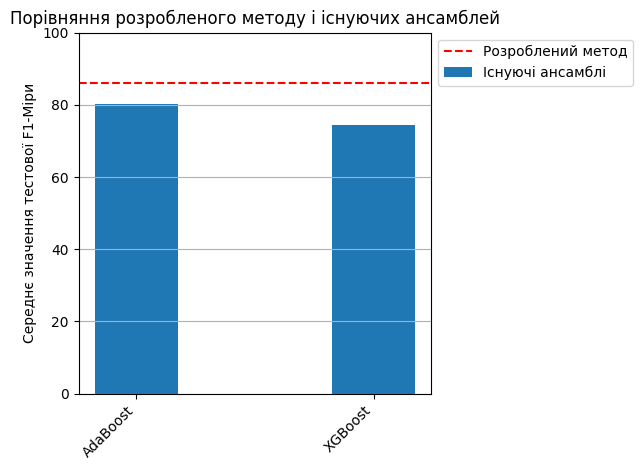

In [21]:
config_best_stup = {
    'estimator': [LinearSVR, LinearSVR],
    'row_scaler': [None],
    'column_scaler': [MaxAbsScaler],
    'y_calc_method': ['norm']

}

run_dataset(X, y, Ensemble, [AdaBoostClassifier, GradientBoostingClassifier], scoring, config_best_stup, plot_func=plot_first_vs_baseline)

# Stupnytskiy's dataset 1

In [29]:
X.shape

(72, 63)

In [28]:
train, test = pd.read_csv('/content/drive/MyDrive/Datasets/Stupnytskiy1Train.txt', sep=',', header=None), pd.read_csv('/content/drive/MyDrive/Datasets/Stupnytskiy1Test.txt', sep=',', header=None)
X_train, y_train = train.drop(train.columns[-1], axis=1), train[train.columns[-1]]
X_test, y_test = test.drop(test.columns[-1], axis=1), test[test.columns[-1]]

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

ALL EXPERIMENTS


,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1_score,test_f1_score,train_matthews_corrcoef,test_matthews_corrcoef,train_cohen_kappa,test_cohen_kappa,experiment_id,estimator,row_scaler,column_scaler,y_calc_method,model
0,97.2 ± 1.4,86.0 ± 7.9,97.0 ± 1.4,88.2 ± 5.4,97.4 ± 1.5,86.9 ± 6.6,97.2 ± 1.4,85.7 ± 8.0,0.944 ± 0.029,0.75 ± 0.118,0.943 ± 0.029,0.724 ± 0.145,1,GTM,None,MaxAbsScaler,norm,Ensemble
1,97.2 ± 1.4,84.7 ± 7.1,97.0 ± 1.4,87.3 ± 4.5,97.4 ± 1.5,85.3 ± 6.2,97.2 ± 1.4,84.1 ± 7.2,0.944 ± 0.029,0.725 ± 0.103,0.943 ± 0.029,0.694 ± 0.129,2,GTM,None,MaxAbsScaler,diff,Ensemble
2,97.2 ± 1.4,86.0 ± 4.7,97.0 ± 1.4,87.6 ± 3.6,97.4 ± 1.5,86.0 ± 4.5,97.2 ± 1.4,85.5 ± 4.7,0.944 ± 0.029,0.735 ± 0.075,0.943 ± 0.029,0.715 ± 0.088,3,GTM,None,MaxAbsScaler,none,Ensemble
3,96.2 ± 2.1,88.7 ± 8.6,95.9 ± 2.1,89.0 ± 8.8,96.5 ± 2.0,88.8 ± 8.3,96.1 ± 2.1,88.5 ± 8.6,0.924 ± 0.04,0.777 ± 0.17,0.922 ± 0.042,0.771 ± 0.171,4,GTM,l2_norm,MaxAbsScaler,norm,Ensemble
4,96.2 ± 2.1,88.7 ± 8.6,95.9 ± 2.1,89.0 ± 8.8,96.5 ± 2.0,88.8 ± 8.3,96.1 ± 2.1,88.5 ± 8.6,0.924 ± 0.04,0.777 ± 0.17,0.922 ± 0.042,0.771 ± 0.171,5,GTM,l2_norm,MaxAbsScaler,diff,Ensemble
5,96.9 ± 1.3,87.3 ± 8.3,96.6 ± 1.3,88.2 ± 8.4,97.1 ± 1.4,87.1 ± 8.4,96.8 ± 1.3,86.9 ± 8.4,0.937 ± 0.027,0.752 ± 0.165,0.936 ± 0.027,0.741 ± 0.167,6,GTM,l2_norm,MaxAbsScaler,none,Ensemble
6,95.1 ± 1.3,88.7 ± 8.6,94.8 ± 1.3,89.0 ± 8.8,95.6 ± 1.4,88.8 ± 8.3,95.0 ± 1.3,88.5 ± 8.6,0.904 ± 0.027,0.777 ± 0.17,0.901 ± 0.027,0.771 ± 0.171,7,GTM,double_l2_norm,MaxAbsScaler,norm,Ensemble
7,95.1 ± 1.3,88.7 ± 8.6,94.8 ± 1.3,89.0 ± 8.8,95.6 ± 1.4,88.8 ± 8.3,95.0 ± 1.3,88.5 ± 8.6,0.904 ± 0.027,0.777 ± 0.17,0.901 ± 0.027,0.771 ± 0.171,8,GTM,double_l2_norm,MaxAbsScaler,diff,Ensemble
8,95.5 ± 1.8,88.7 ± 8.6,95.1 ± 1.8,89.0 ± 8.8,95.9 ± 1.8,88.8 ± 8.3,95.4 ± 1.8,88.5 ± 8.6,0.91 ± 0.036,0.777 ± 0.17,0.908 ± 0.036,0.771 ± 0.171,9,GTM,double_l2_norm,MaxAbsScaler,none,Ensemble
9,97.2 ± 1.4,91.4 ± 8.3,96.9 ± 1.4,92.3 ± 7.0,97.5 ± 1.4,92.1 ± 7.6,97.2 ± 1.4,91.3 ± 8.4,0.944 ± 0.029,0.844 ± 0.146,0.943 ± 0.029,0.831 ± 0.162,10,Ridge,None,MaxAbsScaler,norm,Ensemble


BASELINE EXPERIMENTS


,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1_score,test_f1_score,train_matthews_corrcoef,test_matthews_corrcoef,train_cohen_kappa,test_cohen_kappa,experiment_id,column norm,row norm,model
0,96.9 ± 1.3,83.1 ± 9.8,96.7 ± 1.3,84.5 ± 8.9,97.0 ± 1.4,83.1 ± 9.1,96.8 ± 1.3,82.6 ± 9.8,0.936 ± 0.027,0.674 ± 0.176,0.936 ± 0.027,0.66 ± 0.184,1,max abs column norm,No Row Norm,GTM
1,96.5 ± 1.6,85.9 ± 7.8,96.3 ± 1.6,86.7 ± 8.1,96.8 ± 1.5,85.4 ± 7.7,96.4 ± 1.6,85.5 ± 7.9,0.93 ± 0.031,0.72 ± 0.155,0.929 ± 0.032,0.711 ± 0.157,2,max abs column norm,Row Normalizer,GTM
2,95.5 ± 1.8,88.7 ± 8.6,95.1 ± 1.8,89.0 ± 8.8,95.9 ± 1.8,88.8 ± 8.3,95.4 ± 1.8,88.5 ± 8.6,0.91 ± 0.036,0.777 ± 0.17,0.908 ± 0.036,0.771 ± 0.171,3,max abs column norm,Double Row Normalizer,GTM
0,97.2 ± 1.4,88.8 ± 5.9,96.9 ± 1.4,89.8 ± 6.1,97.5 ± 1.4,88.3 ± 6.0,97.2 ± 1.4,88.3 ± 6.1,0.944 ± 0.029,0.782 ± 0.12,0.943 ± 0.029,0.769 ± 0.12,1,max abs column norm,No Row Norm,Ridge
1,92.4 ± 0.9,84.7 ± 6.9,92.0 ± 0.9,85.1 ± 7.2,92.6 ± 1.2,83.5 ± 7.6,92.2 ± 0.9,83.8 ± 7.3,0.846 ± 0.021,0.686 ± 0.147,0.844 ± 0.019,0.678 ± 0.146,2,max abs column norm,Row Normalizer,Ridge
2,58.3 ± 0.4,58.3 ± 1.4,29.2 ± 0.2,29.1 ± 0.7,50.0 ± 0.0,50.0 ± 0.0,36.8 ± 0.1,36.8 ± 0.6,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,3,max abs column norm,Double Row Normalizer,Ridge
0,100.0 ± 0.0,79.0 ± 8.2,100.0 ± 0.0,80.7 ± 9.9,100.0 ± 0.0,77.5 ± 6.9,100.0 ± 0.0,78.0 ± 7.6,1.0 ± 0.0,0.581 ± 0.165,1.0 ± 0.0,0.564 ± 0.154,1,max abs column norm,No Row Norm,SVM
1,94.4 ± 2.1,87.3 ± 7.2,94.1 ± 2.1,88.1 ± 7.6,94.8 ± 2.2,86.2 ± 7.5,94.3 ± 2.1,86.7 ± 7.5,0.888 ± 0.043,0.743 ± 0.15,0.886 ± 0.042,0.736 ± 0.149,2,max abs column norm,Row Normalizer,SVM
2,63.5 ± 1.4,59.6 ± 5.8,77.5 ± 3.5,49.7 ± 26.0,56.5 ± 2.1,52.1 ± 5.6,50.0 ± 4.2,42.6 ± 8.5,0.26 ± 0.029,0.081 ± 0.216,0.147 ± 0.046,0.048 ± 0.127,3,max abs column norm,Double Row Normalizer,SVM


BEST RESULTS


,test_f1_score_mean
estimator,
GTM,88.5
Ridge,91.3
SVM,87.1


BASELINE BEST RESULTS


,test_f1_score_mean
model,
GTM,88.5
Ridge,88.3
SVM,86.7


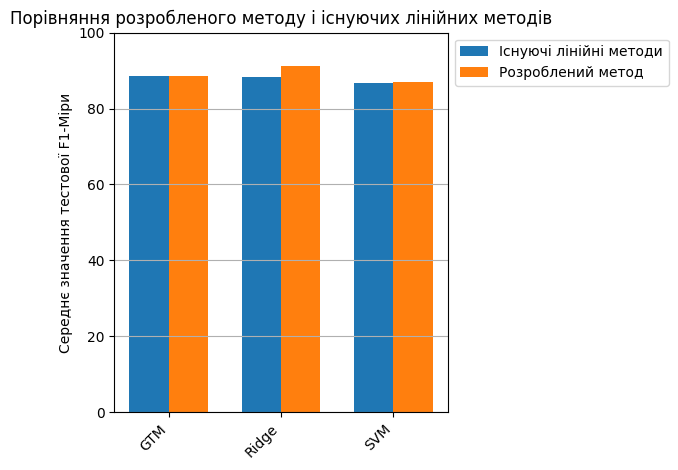

In [23]:
run_dataset(X, y, Ensemble, [GTMClassifier, RidgeClassifier, LinearSVC], scoring, config)

ALL EXPERIMENTS


,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1_score,test_f1_score,train_matthews_corrcoef,test_matthews_corrcoef,train_cohen_kappa,test_cohen_kappa,experiment_id,estimator,row_scaler,column_scaler,y_calc_method,model
0,97.2 ± 1.4,91.4 ± 8.3,96.9 ± 1.4,92.3 ± 7.0,97.5 ± 1.4,92.1 ± 7.6,97.2 ± 1.4,91.3 ± 8.4,0.944 ± 0.029,0.844 ± 0.146,0.943 ± 0.029,0.831 ± 0.162,1,Ridge,None,MaxAbsScaler,norm,Ensemble
1,97.2 ± 1.4,91.4 ± 8.3,96.9 ± 1.4,92.3 ± 7.0,97.5 ± 1.4,92.1 ± 7.6,97.2 ± 1.4,91.3 ± 8.4,0.944 ± 0.029,0.844 ± 0.146,0.943 ± 0.029,0.831 ± 0.162,2,Ridge,None,MaxAbsScaler,norm,Ensemble


BASELINE EXPERIMENTS


,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1_score,test_f1_score,train_matthews_corrcoef,test_matthews_corrcoef,train_cohen_kappa,test_cohen_kappa,experiment_id,column norm,row norm,model
0,100.0 ± 0.0,81.7 ± 7.6,100.0 ± 0.0,82.3 ± 7.6,100.0 ± 0.0,81.4 ± 6.7,100.0 ± 0.0,81.3 ± 7.4,1.0 ± 0.0,0.637 ± 0.142,1.0 ± 0.0,0.629 ± 0.145,1,max abs column norm,No Row Norm,AdaBoost
1,100.0 ± 0.0,77.5 ± 10.8,100.0 ± 0.0,80.4 ± 10.5,100.0 ± 0.0,76.7 ± 8.5,100.0 ± 0.0,76.5 ± 10.6,1.0 ± 0.0,0.568 ± 0.186,1.0 ± 0.0,0.546 ± 0.188,2,max abs column norm,Row Normalizer,AdaBoost
2,100.0 ± 0.0,79.0 ± 4.8,100.0 ± 0.0,80.3 ± 5.9,100.0 ± 0.0,77.6 ± 3.3,100.0 ± 0.0,78.0 ± 4.3,1.0 ± 0.0,0.579 ± 0.09,1.0 ± 0.0,0.565 ± 0.085,3,max abs column norm,Double Row Normalizer,AdaBoost
0,100.0 ± 0.0,83.1 ± 10.8,100.0 ± 0.0,83.4 ± 11.1,100.0 ± 0.0,83.1 ± 10.5,100.0 ± 0.0,82.9 ± 10.8,1.0 ± 0.0,0.664 ± 0.216,1.0 ± 0.0,0.659 ± 0.214,1,max abs column norm,No Row Norm,XGBoost
1,100.0 ± 0.0,75.0 ± 9.5,100.0 ± 0.0,76.3 ± 8.6,100.0 ± 0.0,74.4 ± 9.9,100.0 ± 0.0,73.7 ± 9.9,1.0 ± 0.0,0.506 ± 0.184,1.0 ± 0.0,0.487 ± 0.19,2,max abs column norm,Row Normalizer,XGBoost
2,100.0 ± 0.0,72.0 ± 12.3,100.0 ± 0.0,72.4 ± 11.7,100.0 ± 0.0,71.5 ± 11.1,100.0 ± 0.0,71.3 ± 11.9,1.0 ± 0.0,0.439 ± 0.228,1.0 ± 0.0,0.434 ± 0.229,3,max abs column norm,Double Row Normalizer,XGBoost


BEST RESULTS


,test_f1_score_mean
estimator,
Ridge,91.3


BASELINE BEST RESULTS


,test_f1_score_mean
model,
AdaBoost,81.3
XGBoost,82.9


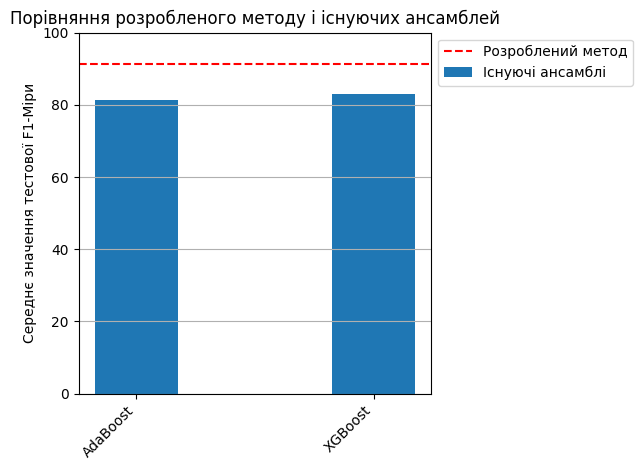

In [24]:
config_best_stup1 = {
    'estimator': [Ridge, Ridge],
    'row_scaler': [None],
    'column_scaler': [MaxAbsScaler],
    'y_calc_method': ['norm']

}

run_dataset(X, y, Ensemble, [AdaBoostClassifier, GradientBoostingClassifier], scoring, config_best_stup1, plot_func=plot_first_vs_baseline)

# Transplantant Dataset



In [25]:
train, test = pd.read_csv('/content/drive/MyDrive/Datasets/TransplantantTrain.txt', sep=',', header=None), pd.read_csv('/content/drive/MyDrive/Datasets/TransplantantTest.txt', sep=',', header=None)
X_train, y_train = train.drop(train.columns[-1], axis=1), train[train.columns[-1]]
X_test, y_test = test.drop(test.columns[-1], axis=1), test[test.columns[-1]]

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

ALL EXPERIMENTS


,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1_score,test_f1_score,train_matthews_corrcoef,test_matthews_corrcoef,train_cohen_kappa,test_cohen_kappa,experiment_id,estimator,row_scaler,column_scaler,y_calc_method,model
0,94.5 ± 1.9,88.3 ± 4.7,95.1 ± 1.8,86.4 ± 6.9,90.3 ± 3.6,81.4 ± 6.8,92.3 ± 2.7,83.4 ± 6.9,0.853 ± 0.05,0.676 ± 0.136,0.846 ± 0.054,0.669 ± 0.137,1,GTM,None,MaxAbsScaler,norm,Ensemble
1,94.3 ± 2.0,87.6 ± 3.5,95.0 ± 1.8,86.0 ± 6.2,90.0 ± 4.0,80.0 ± 4.7,92.0 ± 3.0,82.3 ± 5.1,0.848 ± 0.054,0.657 ± 0.105,0.841 ± 0.06,0.647 ± 0.103,2,GTM,None,MaxAbsScaler,diff,Ensemble
2,95.2 ± 1.7,88.3 ± 3.5,95.5 ± 2.2,85.6 ± 4.7,91.6 ± 2.6,82.4 ± 5.6,93.3 ± 2.4,83.7 ± 5.2,0.871 ± 0.047,0.679 ± 0.102,0.867 ± 0.047,0.675 ± 0.104,3,GTM,None,MaxAbsScaler,none,Ensemble
3,94.7 ± 1.3,91.0 ± 4.1,94.3 ± 2.1,88.9 ± 5.6,91.8 ± 2.6,87.7 ± 6.5,92.8 ± 1.8,88.0 ± 5.7,0.859 ± 0.033,0.766 ± 0.115,0.855 ± 0.035,0.76 ± 0.115,4,GTM,l2_norm,MaxAbsScaler,norm,Ensemble
4,94.7 ± 1.3,91.0 ± 4.1,94.3 ± 2.1,88.9 ± 5.6,91.8 ± 2.6,87.7 ± 6.5,92.8 ± 1.8,88.0 ± 5.7,0.859 ± 0.033,0.766 ± 0.115,0.855 ± 0.035,0.76 ± 0.115,5,GTM,l2_norm,MaxAbsScaler,diff,Ensemble
5,94.8 ± 0.9,89.7 ± 4.9,94.6 ± 0.8,87.7 ± 6.9,91.6 ± 2.1,84.3 ± 7.0,92.9 ± 1.4,85.7 ± 7.0,0.862 ± 0.027,0.719 ± 0.138,0.859 ± 0.028,0.715 ± 0.139,6,GTM,l2_norm,MaxAbsScaler,none,Ensemble
6,94.1 ± 2.6,89.0 ± 4.0,92.9 ± 4.2,86.5 ± 5.9,92.5 ± 3.3,87.3 ± 4.8,92.3 ± 3.1,86.0 ± 4.8,0.853 ± 0.059,0.735 ± 0.093,0.847 ± 0.062,0.723 ± 0.096,7,GTM,double_l2_norm,MaxAbsScaler,norm,Ensemble
7,94.1 ± 2.6,89.0 ± 4.0,92.9 ± 4.2,86.5 ± 5.9,92.5 ± 3.3,87.3 ± 4.8,92.3 ± 3.1,86.0 ± 4.8,0.853 ± 0.059,0.735 ± 0.093,0.847 ± 0.062,0.723 ± 0.096,8,GTM,double_l2_norm,MaxAbsScaler,diff,Ensemble
8,94.8 ± 0.8,91.0 ± 4.7,94.8 ± 0.8,90.1 ± 6.7,91.4 ± 1.6,86.2 ± 5.8,92.9 ± 1.1,87.8 ± 6.2,0.862 ± 0.021,0.761 ± 0.124,0.859 ± 0.023,0.756 ± 0.124,9,GTM,double_l2_norm,MaxAbsScaler,none,Ensemble
9,94.1 ± 1.3,90.3 ± 4.0,93.6 ± 1.8,88.6 ± 5.7,91.0 ± 2.6,85.5 ± 5.6,92.0 ± 1.8,86.8 ± 5.6,0.844 ± 0.034,0.74 ± 0.11,0.841 ± 0.036,0.736 ± 0.111,10,Ridge,None,MaxAbsScaler,norm,Ensemble


BASELINE EXPERIMENTS


,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1_score,test_f1_score,train_matthews_corrcoef,test_matthews_corrcoef,train_cohen_kappa,test_cohen_kappa,experiment_id,column norm,row norm,model
0,94.7 ± 1.7,89.7 ± 4.9,94.7 ± 2.1,87.7 ± 6.9,91.1 ± 2.7,84.3 ± 7.0,92.6 ± 2.4,85.7 ± 7.0,0.856 ± 0.047,0.719 ± 0.138,0.853 ± 0.047,0.715 ± 0.139,1,max abs column norm,No Row Norm,GTM
1,95.0 ± 1.0,89.7 ± 4.9,94.9 ± 0.9,87.7 ± 6.9,91.8 ± 2.1,84.3 ± 7.0,93.2 ± 1.5,85.7 ± 7.0,0.866 ± 0.028,0.719 ± 0.138,0.863 ± 0.029,0.715 ± 0.139,2,max abs column norm,Row Normalizer,GTM
2,94.8 ± 0.8,91.0 ± 4.7,94.8 ± 0.8,90.1 ± 6.7,91.4 ± 1.6,86.2 ± 5.8,92.9 ± 1.1,87.8 ± 6.2,0.862 ± 0.021,0.761 ± 0.124,0.859 ± 0.023,0.756 ± 0.124,3,max abs column norm,Double Row Normalizer,GTM
0,94.0 ± 1.2,90.3 ± 4.6,93.9 ± 1.4,89.4 ± 7.2,89.9 ± 2.2,84.6 ± 6.9,91.7 ± 1.8,86.4 ± 6.7,0.838 ± 0.034,0.737 ± 0.134,0.834 ± 0.036,0.729 ± 0.135,1,max abs column norm,No Row Norm,Ridge
1,86.7 ± 1.7,84.1 ± 4.1,90.2 ± 1.8,87.1 ± 6.9,74.8 ± 3.6,70.5 ± 8.4,78.7 ± 3.7,73.1 ± 8.6,0.631 ± 0.058,0.543 ± 0.139,0.585 ± 0.069,0.484 ± 0.158,2,max abs column norm,Row Normalizer,Ridge
2,74.5 ± 0.4,74.5 ± 1.7,37.2 ± 0.2,37.2 ± 0.8,50.0 ± 0.0,50.0 ± 0.0,42.7 ± 0.1,42.7 ± 0.6,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,3,max abs column norm,Double Row Normalizer,Ridge
0,91.0 ± 1.9,85.5 ± 4.0,94.3 ± 1.0,88.9 ± 4.7,82.6 ± 3.9,73.0 ± 9.5,86.4 ± 3.4,75.6 ± 8.3,0.759 ± 0.051,0.588 ± 0.129,0.733 ± 0.064,0.53 ± 0.157,1,max abs column norm,No Row Norm,SVM
1,90.7 ± 2.1,85.5 ± 4.0,94.1 ± 1.1,88.9 ± 4.7,82.0 ± 4.5,73.0 ± 9.5,85.8 ± 4.1,75.6 ± 8.3,0.749 ± 0.061,0.588 ± 0.129,0.72 ± 0.078,0.53 ± 0.157,2,max abs column norm,Row Normalizer,SVM
2,74.5 ± 0.4,74.5 ± 1.7,37.2 ± 0.2,37.2 ± 0.8,50.0 ± 0.0,50.0 ± 0.0,42.7 ± 0.1,42.7 ± 0.6,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,3,max abs column norm,Double Row Normalizer,SVM


BEST RESULTS


,test_f1_score_mean
estimator,
GTM,88.0
Ridge,88.0
SVM,80.0


BASELINE BEST RESULTS


,test_f1_score_mean
model,
GTM,87.8
Ridge,86.4
SVM,75.6


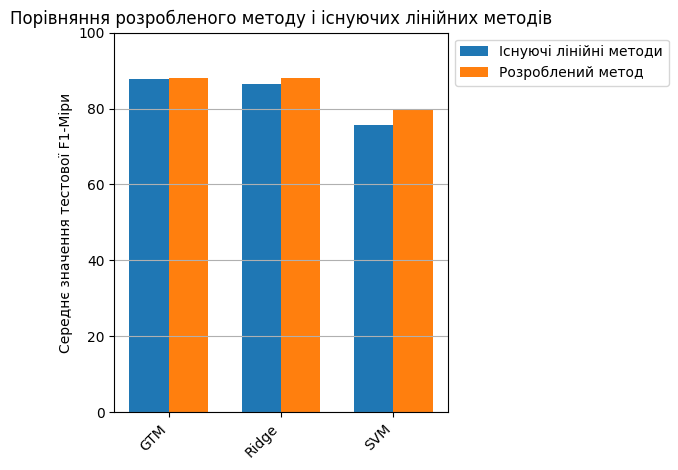

In [26]:
run_dataset(X, y, Ensemble, [GTMClassifier, RidgeClassifier, SVC], scoring, config)

ALL EXPERIMENTS


,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1_score,test_f1_score,train_matthews_corrcoef,test_matthews_corrcoef,train_cohen_kappa,test_cohen_kappa,experiment_id,estimator,row_scaler,column_scaler,y_calc_method,model
0,92.1 ± 1.0,91.7 ± 4.1,91.2 ± 1.7,91.4 ± 5.1,87.6 ± 1.8,86.3 ± 7.8,89.1 ± 1.5,88.0 ± 6.5,0.786 ± 0.028,0.773 ± 0.123,0.782 ± 0.029,0.762 ± 0.128,1,Ridge,l2_norm,MaxAbsScaler,norm,Ensemble
1,92.1 ± 1.0,91.7 ± 4.1,91.2 ± 1.7,91.4 ± 5.1,87.6 ± 1.8,86.3 ± 7.8,89.1 ± 1.5,88.0 ± 6.5,0.786 ± 0.028,0.773 ± 0.123,0.782 ± 0.029,0.762 ± 0.128,2,Ridge,l2_norm,MaxAbsScaler,norm,Ensemble


BASELINE EXPERIMENTS


,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1_score,test_f1_score,train_matthews_corrcoef,test_matthews_corrcoef,train_cohen_kappa,test_cohen_kappa,experiment_id,column norm,row norm,model
0,100.0 ± 0.0,86.9 ± 7.0,100.0 ± 0.0,85.1 ± 11.5,100.0 ± 0.0,77.6 ± 11.3,100.0 ± 0.0,80.0 ± 11.6,1.0 ± 0.0,0.621 ± 0.225,1.0 ± 0.0,0.604 ± 0.227,1,max abs column norm,No Row Norm,XGBoost
1,100.0 ± 0.0,82.8 ± 7.9,100.0 ± 0.0,78.6 ± 10.8,100.0 ± 0.0,75.0 ± 9.2,100.0 ± 0.0,76.4 ± 9.9,1.0 ± 0.0,0.535 ± 0.199,1.0 ± 0.0,0.529 ± 0.198,2,max abs column norm,Row Normalizer,XGBoost
2,100.0 ± 0.0,84.8 ± 6.0,100.0 ± 0.0,80.7 ± 8.6,100.0 ± 0.0,77.2 ± 9.6,100.0 ± 0.0,78.4 ± 9.3,1.0 ± 0.0,0.577 ± 0.18,1.0 ± 0.0,0.57 ± 0.184,3,max abs column norm,Double Row Normalizer,XGBoost
0,100.0 ± 0.0,89.7 ± 7.2,100.0 ± 0.0,87.9 ± 9.1,100.0 ± 0.0,83.0 ± 12.6,100.0 ± 0.0,84.4 ± 11.7,1.0 ± 0.0,0.704 ± 0.218,1.0 ± 0.0,0.692 ± 0.229,1,max abs column norm,No Row Norm,AdaBoost
1,100.0 ± 0.0,88.3 ± 4.7,100.0 ± 0.0,85.7 ± 7.0,100.0 ± 0.0,85.2 ± 6.1,100.0 ± 0.0,84.6 ± 6.0,1.0 ± 0.0,0.706 ± 0.12,1.0 ± 0.0,0.695 ± 0.12,2,max abs column norm,Row Normalizer,AdaBoost
2,100.0 ± 0.0,86.2 ± 6.9,100.0 ± 0.0,82.0 ± 9.8,100.0 ± 0.0,82.6 ± 9.8,100.0 ± 0.0,81.9 ± 9.4,1.0 ± 0.0,0.645 ± 0.191,1.0 ± 0.0,0.639 ± 0.188,3,max abs column norm,Double Row Normalizer,AdaBoost


BEST RESULTS


,test_f1_score_mean
estimator,
Ridge,88.0


BASELINE BEST RESULTS


,test_f1_score_mean
model,
AdaBoost,84.6
XGBoost,80.0


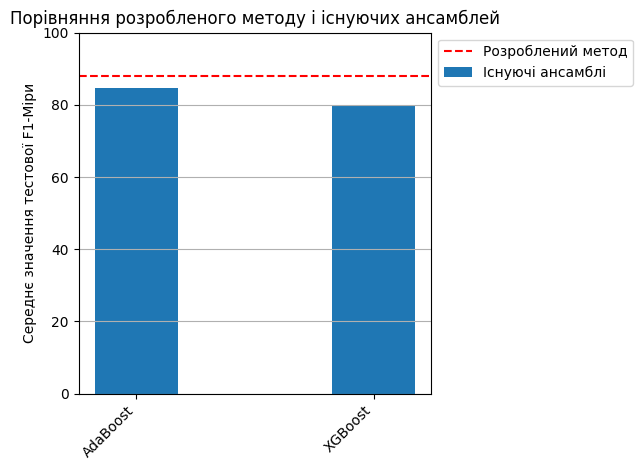

In [27]:
config_best_transp = {
    'estimator': [Ridge, Ridge],
    'row_scaler': [l2_norm],
    'column_scaler': [MaxAbsScaler],
    'y_calc_method': ['norm']

}

run_dataset(X, y, Ensemble, [GradientBoostingClassifier, AdaBoostClassifier], scoring, config_best_transp, plot_func=plot_first_vs_baseline)